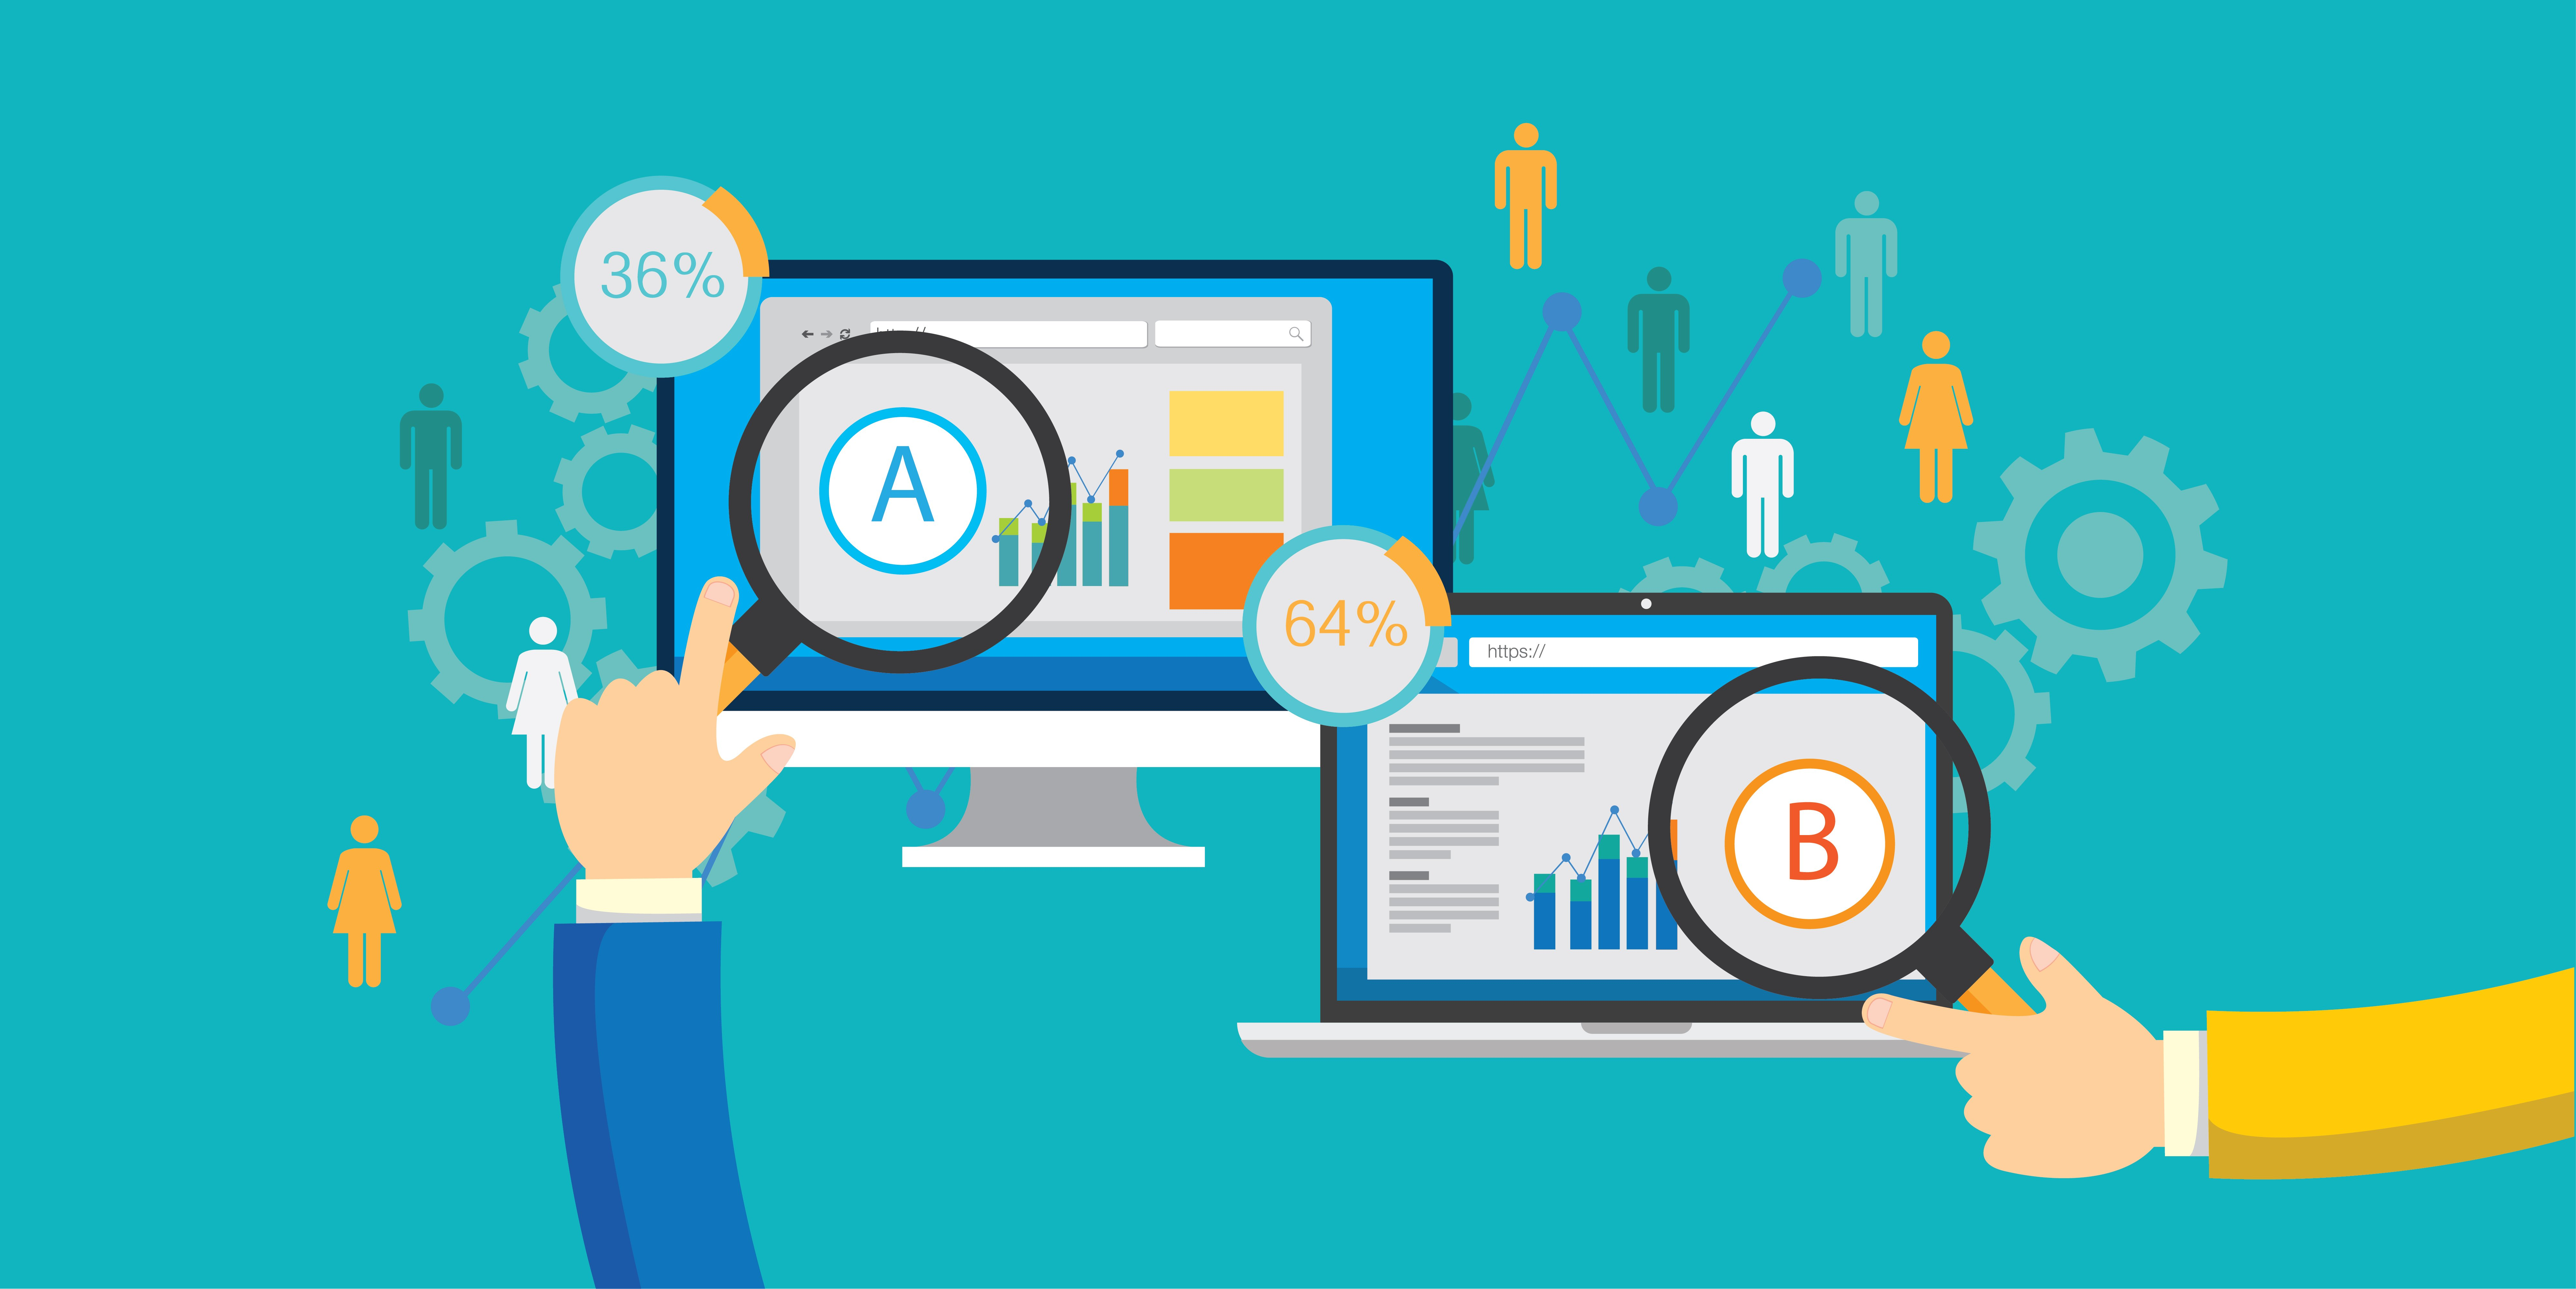

# Project Overview: Evaluating a New Search Ranking Algorithm via A/B Testing

As a Data Scientist at an online travel platform, my goal is to assess the effectiveness of a newly proposed search ranking algorithm. The aim of this algorithm is to enhance the **conversion rate** — i.e., the proportion of sessions that result in bookings — without negatively impacting the **time to book**.

To make a confident, data-driven decision on whether the new algorithm should be fully rolled out, the following criteria were established:

**Primary Metric (Conversion Rate):**  
Must show a statistically significant and positive improvement in the variant group compared to the control.

**Guardrail Metric (Time to Booking):**  
Must show no significant delay or ideally an improvement in booking time.

## Data Provided
- **users_data.csv**: Contains user-level assignment to either control or variant group.  
- **sessions_data.csv**: Contains session-level metrics, including booking outcomes and time to booking.

## Objective
Analyze and interpret the A/B testing results to:  
1. Determine whether the new algorithm leads to a measurable and statistically valid uplift in conversions.  
2. Ensure it does not increase friction (i.e., delay) in the booking process.  
3. Provide a clear recommendation on whether the new system should be deployed across the platform.

## `sessions_data.csv`

| column | data type | description |
|--------|-----------|-------------|
| `session_id` | `string` | Unique session identifier (unique for each row) |
| `user_id` | `string` | Unique user identifier (non logged-in users have missing user_id values; each user can have multiple sessions) |
| `session_start_timestamp` | `string` | When a session started |
| `booking_timestamp` | `string` | When a booking was made (missing if no booking was made during a session) |
| `time_to_booking` | `float` | time from start of the session to booking, in minutes (missing if no booking was made during a session) |
| `conversion` | `integer` | _New column to create:_ did session end up with a booking (0 if booking_timestamp or time_to_booking is Null, otherwise 1) |

<br>

## `users_data.csv`

| column | data type | description |
|--------|-----------|-------------|
| `user_id` | `string` | Unique user identifier (only logged-in users in this table) |
| `experiment_group` | `string` | control / variant split for the experiment (expected to be equal 50/50) |

<br>

# A/B Test Evaluation Criteria

To determine whether the new search ranking algorithm should be fully rolled out, the following criteria must be met:

- **Primary Metric (Conversion Rate):**  
  The effect must be **statistically significant** (p-value < Alpha) and show a **positive effect** (increase in conversion rate) in the variant group compared to the control group.

- **Guardrail Metric (Time to Booking):**  
  The effect must either be **statistically insignificant** (p-value ≥ Alpha, indicating no significant delay) or show a **positive effect** (decrease in average time to booking) in the variant group compared to the control group.

In [3]:
import pandas as pd
from scipy.stats import chisquare
from pingouin import ttest
from statsmodels.stats.proportion import proportions_ztest

In [4]:
sessions = pd.read_csv('sessions_data.csv')
users = pd.read_csv('users_data.csv')

In [5]:
sessions.sample(5)

session_id           user_id        session_start_timestamp  \
14549  d5tguY53jTAlpr13  hM9LZlAwz0jh09U7  2025-01-18 20:59:55.702812910   
6462   YBcCdQNF2xCs0oNF               NaN  2025-01-13 04:07:44.934947729   
7536   fS7uzeIsXBB7itdT  r8s7uJZwbKlswOmn  2025-01-25 22:17:36.853731871   
8420   obiDw84gNK0pQsGy  RCibAyyCPvqe4RkI  2025-01-18 15:04:57.440915823   
4705   pnDJTra7Wl6CYgIT  QhjrqQF8akIuIogm  2025-01-19 15:10:03.704571962   

                   booking_timestamp  time_to_booking  
14549  2025-01-18 21:21:45.447660670        21.829081  
6462   2025-01-13 04:17:48.066190888        10.052187  
7536                             NaN              NaN  
8420                             NaN              NaN  
4705                             NaN              NaN

In [6]:
users.sample(5)

user_id experiment_group
3203  0xvBG3r7qTLBPCDd          variant
9328  GvE6xVbuZTAw53Fy          variant
4355  KAz84BehQF2pPDzt          control
8713  JIUEbypgKUDVZGFc          variant
2221  7Sv1GT0rqzr8diZ3          control

### Your solution

In [7]:
confidence_level = 0.90  # Set the pre-defined confidence level (90%)
alpha = 1 - confidence_level  # Significance level for hypothesis tests

In [8]:
# JOIN DATA
# Merge on user ID to enrich sessions with user experiment group
sessions_x_users = sessions.merge(users, on = 'user_id', how = 'inner')

In [9]:
sessions_x_users.head()

session_id           user_id        session_start_timestamp  \
0  CP0lbAGnb5UNi3Ut  TcCIMrtQ75wHGXVj  2025-01-26 20:02:39.177358627   
1  UQAjrPYair63L1p8  TcCIMrtQ75wHGXVj  2025-01-20 16:12:51.536912203   
2  9zQrAPxV5oi2SzSa  TcCIMrtQ75wHGXVj  2025-01-28 03:46:40.839362144   
3  kkrz1M5vxrQ8wXRZ  GUGVzto9KGqeX3dc  2025-01-25 02:48:50.953303099   
4  ABZZFrwItZAPdYGP  v2EBIHmOdQfalI6k  2025-01-11 11:41:36.912253618   

  booking_timestamp  time_to_booking experiment_group  
0               NaN              NaN          variant  
1               NaN              NaN          variant  
2               NaN              NaN          variant  
3               NaN              NaN          variant  
4               NaN              NaN          variant

In [10]:
# COMPUTE PRIMARY METRIC
# Binary conversion flag: 1 if booking occurred, 0 otherwise
sessions_x_users['conversion'] = sessions_x_users['booking_timestamp'].notnull().astype(int)


# Sample Ratio Mismatch (SRM) Check

To ensure the integrity of the experiment, we performed a **Sample Ratio Mismatch (SRM) test** to verify that the users were randomly assigned to the control and variant groups according to the intended **50:50 ratio**.

- **Null Hypothesis (H₀):** The observed split matches the expected 50:50 distribution.  
- **Alternative Hypothesis (H₁):** The observed split significantly deviates from the expected ratio.

We applied a **Chi-Square goodness-of-fit test** using the observed counts in each group.

- **Decision Rule:**
  - If **p-value < Alpha** → SRM is present, indicating a potential issue with randomization.
  - If **p-value ≥ Alpha** → No SRM detected, suggesting the split aligns with the expected ratio.

In [21]:
groups_count = sessions_x_users['experiment_group'].value_counts()
print(groups_count)

n = sessions_x_users.shape[0] # Total sample size
srm_chi2_stat, srm_chi2_pval = chisquare(f_obs = groups_count, f_exp = (n/2, n/2))
srm_chi2_pval = round(srm_chi2_pval, 4)
print(f'\nSRM\np-value: {srm_chi2_pval}')


experiment_group
variant    7653
control    7630
Name: count, dtype: int64

SRM
p-value: 0.8524


### Effect Size Analysis

In addition to statistical significance (p-values), it is essential to understand the **magnitude of the effect** caused by the experiment.

For this analysis, we use **Relative Effect** as our effect size metric, calculated as:

$$
\text{Relative Effect} = \frac{\text{Mean}_\text{Variant}}{\text{Mean}_\text{Control}} - 1
$$

This gives the **percentage change** in the metric due to the variant compared to the control.

- For the **primary metric (conversion rate)**, a positive relative effect indicates an increase in conversions.
- For the **guardrail metric (time to booking)**, a negative relative effect indicates faster bookings.

This helps us determine not just **if** the result is significant, but also **how meaningful** the change is in practical terms.


In [22]:

def estimate_effect_size(df: pd.DataFrame, metric: str) -> float:
    """
    Calculate relative effect size

    Parameters:
    - df (pd.DataFrame): data with experiment_group ('control', 'variant') and metric columns.
    - metric (str): name of the metric column

    Returns:
    - effect_size (float): average treatment effect (effect size)
    """
    avg_metric_per_group = df.groupby('experiment_group')[metric].mean()
    effect_size = avg_metric_per_group['variant'] / avg_metric_per_group['control'] - 1
    return effect_size


### Hypotheses

**Primary Metric – Conversion Rate**  
- H₀: No difference in conversion rates between control and variant.  
- H₁: Variant has a higher conversion rate than control.

**Guardrail Metric – Time to Booking**  
- H₀: No difference in average time to booking.  
- H₁: Variant has significantly longer booking time.


In [23]:

# EFFECT ANALYSIS - PRIMARY METRIC
# Compute success counts and sample sizes for each group
success_counts = sessions_x_users.groupby('experiment_group')['conversion'].sum().loc[['control', 'variant']]
sample_sizes = sessions_x_users['experiment_group'].value_counts().loc[['control', 'variant']]

# Run Z-test for proportions (binary conversion metric)
zstat_primary, pval_primary = proportions_ztest(
    success_counts,
    sample_sizes,
    alternative = 'two-sided',
)
pval_primary = round(pval_primary, 4)

# Estimate effect size for the conversion metric
effect_size_primary = estimate_effect_size(sessions_x_users, 'conversion')
effect_size_primary = round(effect_size_primary, 4)
print(f'\nPrimary metric\np-value: {pval_primary: .4f} | effect size: {effect_size_primary: .4f}')

# EFFECT ANALYSIS - GUARDRAIL METRIC
# T-test on time to booking for control vs variant
stats_guardrail = ttest(
    sessions_x_users.loc[(sessions_x_users['experiment_group'] == 'control'), 'time_to_booking'],
    sessions_x_users.loc[(sessions_x_users['experiment_group'] == 'variant'), 'time_to_booking'],
    alternative='two-sided',
)
pval_guardrail, tstat_guardrail = stats_guardrail['p-val'].values[0], stats_guardrail['T'].values[0]
pval_guardrail = round(pval_guardrail, 4)

# Estimate effect size for the guardrail metric
effect_size_guardrail = estimate_effect_size(sessions_x_users, 'time_to_booking')
effect_size_guardrail = round(effect_size_guardrail, 4)
print(f'\nGuardrail\np-value: {pval_guardrail} | effect size: {effect_size_guardrail}')



Primary metric
p-value:  0.0002 | effect size:  0.1422

Guardrail
p-value: 0.5365 | effect size: -0.0079


In [24]:

# DECISION
# Primary metric must be statistically significant and show positive effect (increase)
criteria_full_on_primary = (pval_primary < alpha) & (effect_size_primary > 0)

# Guardrail must either be statistically insignificant or whow positive effect (decrease)
criteria_full_on_guardrail = (pval_guardrail > alpha) | (effect_size_guardrail <= 0)

# Final launch decision based on both metrics
if criteria_full_on_primary and criteria_full_on_guardrail:
    decision_full_on = 'Yes'
    print('\nThe experiment results are significantly positive and the guardrail metric was not harmed, we are going full on!')
else:
    decision_full_on = 'No'
    print('\nThe experiment results are inconclusive or the guardrail metric was harmed, we are pulling back!')


The experiment results are significantly positive and the guardrail metric was not harmed, we are going full on!


### Final Decision Summary

To evaluate whether the new search ranking algorithm should be fully rolled out, we assessed both the primary and guardrail metrics using statistical testing and effect size analysis at a significance level of **α = 0.10**.

**Decision Criteria:**

- **Primary Metric (Conversion Rate):**
  - The result must be statistically significant (p-value < α)
  - The relative effect must be positive (indicating improvement)

- **Guardrail Metric (Time to Booking):**
  - The result must either be statistically insignificant (p-value ≥ α), or
  - Show a favorable or neutral effect (no increase in time to book)

**Results:**

- The primary metric showed a statistically significant improvement with a **14.22% increase** in conversion rate.
- The guardrail metric was statistically insignificant and showed a **slight decrease** in time to booking (**-0.79%**), indicating no harm to user experience.

**Conclusion:**

All predefined conditions were satisfied. The experiment demonstrates a **statistically and practically meaningful improvement** in the primary metric without negatively impacting the guardrail metric.

**Recommendation:** Proceed with a **full rollout** of the new ranking algorithm.
